# Train Transformers
Train a small BERT model to predict adherence

In [1]:
import pandas as pd
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline

Load the dataset:

In [2]:
df = pd.read_csv('../../mnt/adherence.csv')
df = df[["c_Action_required_deid_removed", "adherence"]]

ds = datasets.Dataset.from_pandas(df)
ds = ds.train_test_split(test_size=0.2)

# Remap the labels
ds = ds.map(lambda x: {"label": "adherence" if x["adherence"] else "non-adherence"})
ds = ds.class_encode_column("label")
ds = ds.remove_columns(["adherence"])
ds = ds.rename_column("c_Action_required_deid_removed", "text")

id2label = {id: label for id, label in enumerate(ds["train"].features["label"].names)}
label2id = {label: id for id, label in enumerate(ds["train"].features["label"].names)}

Map:   0%|          | 0/2156 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2156 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/540 [00:00<?, ? examples/s]

Tokenize the data:

In [7]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)
ds = ds.map(tokenize_function, batched=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Map:   0%|          | 0/2156 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label), id2label=id2label, label2id=label2id)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": (preds == labels).mean(),
        "f1": f1_score(labels, preds, average="weighted")
    }

Train the model:

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    output_dir="./output/bert",
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    #processing_class=tokenizer,
    #data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

## Evaluate

In [3]:
model_name = "../../unsloth/output/bert/checkpoint-400"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cuda:0
/home/thomas/Documents/discharge/repos/adherence/env/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [39]:
import torch 
from tqdm import tqdm
import torch.nn.functional as F

y_trues = []
y_preds_proba = []
y_preds = []

for row in tqdm(ds["test"]):
    y_trues.append(row["label"])
    inputs = tokenizer(row["text"], return_tensors="pt").to(0)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # shape: [batch_size, num_classes]
    positive_class_probs = probs[:, 1]
    y_preds_proba.extend(positive_class_probs.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [00:02<00:00, 185.65it/s]


In [42]:
from sklearn.metrics import roc_auc_score,average_precision_score

auroc = roc_auc_score(y_trues, y_preds_proba)
auprc = average_precision_score(y_trues, y_preds_proba)
print("AUROC:", auroc)
print("AURPC:", auprc)

AUROC: 0.9397740075551727
AURPC: 0.8947055310798772


## Explainability

In [24]:
import shap
explainer = shap.Explainer(pipe)
shap_values = explainer(ds["test"]["text"][:100])

PartitionExplainer explainer: 101it [04:00,  2.50s/it]                                                                                                                                      


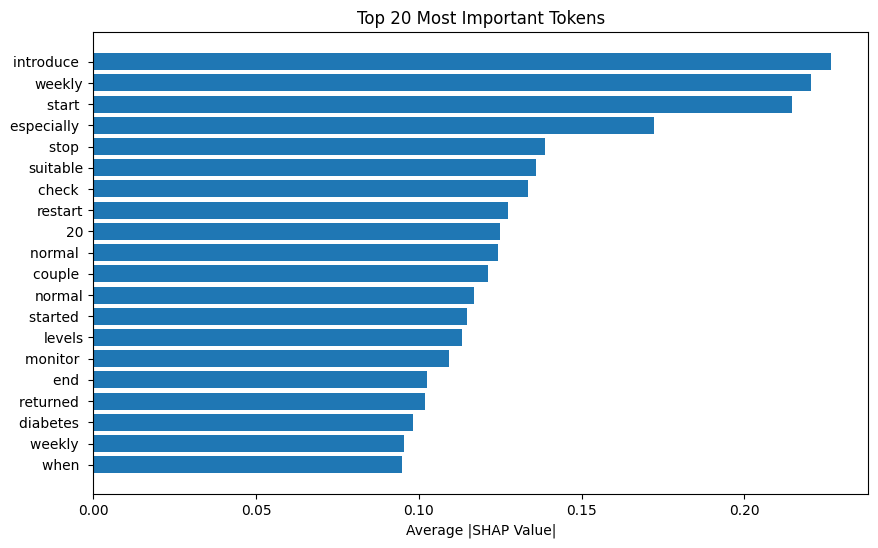

In [25]:
from collections import defaultdict
import numpy as np

token_scores = defaultdict(list)

for explanation in shap_values:
    for token, value in zip(explanation.data, explanation.values):
        token_scores[token.lower()].append(abs(value))  # use abs to get magnitude of impact

# Average impact per token
avg_impact = {token: np.mean(vals) for token, vals in token_scores.items()}

# Top 20 tokens by average impact
top_tokens = sorted(avg_impact.items(), key=lambda x: x[1], reverse=True)[:20]

import matplotlib.pyplot as plt

tokens, impacts = zip(*top_tokens)
plt.figure(figsize=(10, 6))
plt.barh(tokens[::-1], impacts[::-1])  # reverse for top-down
plt.xlabel("Average |SHAP Value|")
plt.title("Top 20 Most Important Tokens")
plt.show()

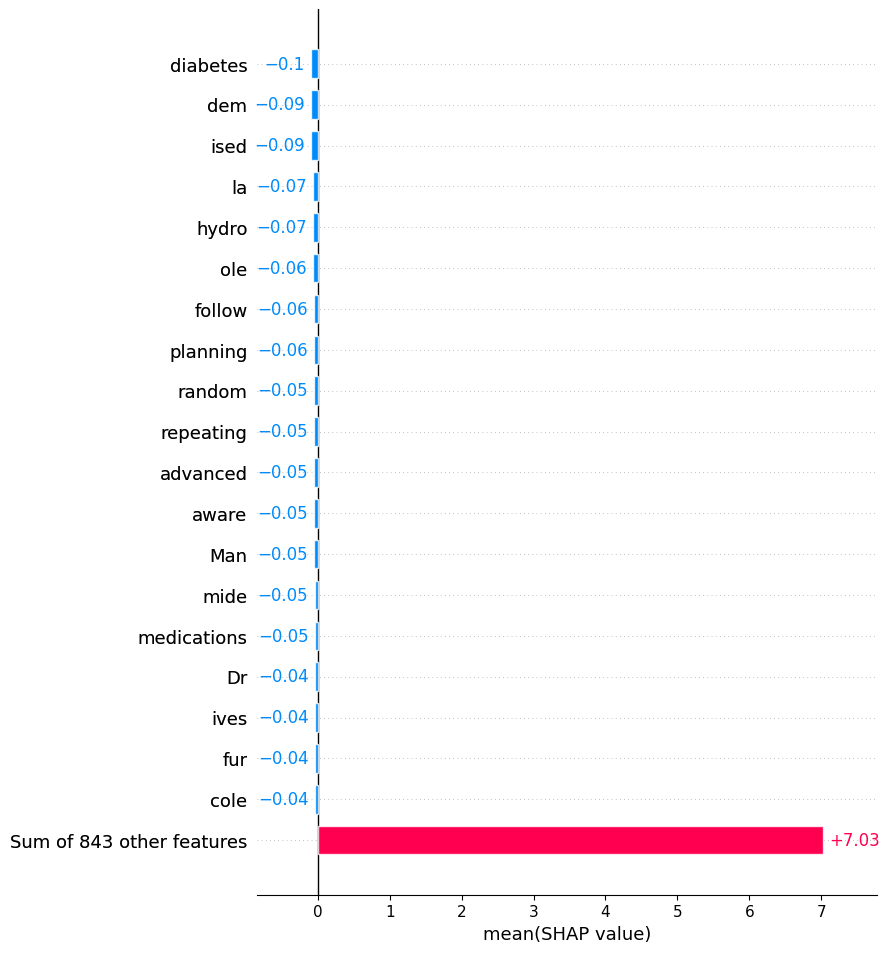

In [29]:

shap.plots.bar(shap_values[:, :, "adherence"].mean(0), order=shap.Explanation.argsort, max_display=20)